# Yolo_v5

### Yolo v5 다운로드 및 설치

ultralytics 라이브러리를 사용 

In [1]:
# Google Drive 접근을 위한 Mount 적용.
import os, sys
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5;pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 14112, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 14112 (delta 221), reused 219 (delta 143), pack-reused 13783
Receiving objects: 100% (14112/14112), 13.62 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (9663/9663), done.
     |████████████████████████████████| 182 kB 31.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 1.6 MB 46.4 MB/s 


### COCO 포맷을 Ultralytics yolo 포맷으로 변환

1. https://github.com/alexmihalyk23/COCO2YOLO.git 를 약간 수정하여 변환로직 생성.

2. 소스 이미지 디렉토리와 Json annotation 파일, 타겟 이미지 디렉토리, 타겟 annotation 디렉토리를 기반으로 train/val/test Json annotation 파일에 따라 소스 이미지 디렉토리에 있는 파일들은 타겟 이미지 디렉토리로 단순 복사하고, annotation 파일은 yolo 포맷으로 변환하여 타겟 annotation 디렉토리로 저장

3. 한개의 json annotation 파일이 여러개의 yolo 포맷 annotation 파일로 변환됨.

4. Ultralytics 도 JSON2Yolo 를 제공하나, 적용 시 coco dataset의 customization이 별도 필요.

In [3]:
# https://github.com/alexmihalyk23/COCO2YOLO.git
import json
import os
import shutil

class COCO2YOLO:
  # 소스 이미지 디렉토리와 Json annotation 파일, 타겟 이미지 디렉토리, 타겟 annotation 디렉토리를 생성자로 입력 받음. 
  def __init__(self, src_img_dir, json_file, tgt_img_dir, tgt_anno_dir):
    self.json_file = json_file
    self.src_img_dir = src_img_dir
    self.tgt_img_dir = tgt_img_dir
    self.tgt_anno_dir = tgt_anno_dir
    # json 파일과 타겟 디렉토리가 존재하는지 확인하고, 디렉토리의 경우는 없으면 생성. 
    self._check_file_and_dir(json_file, tgt_img_dir, tgt_anno_dir)
    # json 파일을 메모리로 로딩. 
    self.labels = json.load(open(json_file, 'r', encoding='utf-8'))
    # category id와 이름을 매핑하지만, 실제 class id는 이를 적용하지 않고 별도 적용. 
    self.coco_id_name_map = self._categories()
    self.coco_name_list = list(self.coco_id_name_map.values())
    print("total images", len(self.labels['images']))
    print("total categories", len(self.labels['categories']))
    print("total labels", len(self.labels['annotations']))
  
  # json 파일과 타겟 디렉토리가 존재하는지 확인하고, 디렉토리의 경우는 없으면 생성. 
  def _check_file_and_dir(self, file_path, tgt_img_dir, tgt_anno_dir):
    if not os.path.exists(file_path):
        raise ValueError("file not found")
    if not os.path.exists(tgt_img_dir):
        os.makedirs(tgt_img_dir)
    if not os.path.exists(tgt_anno_dir):
        os.makedirs(tgt_anno_dir)

  # category id와 이름을 매핑하지만, 추후에 class 명만 활용. 
  def _categories(self):
    categories = {}
    for cls in self.labels['categories']:
        categories[cls['id']] = cls['name']
    return categories
  
  # annotation에서 모든 image의 파일명(절대 경로 아님)과 width, height 정보 저장. 
  def _load_images_info(self):
    images_info = {}
    for image in self.labels['images']:
        id = image['id']
        file_name = image['file_name']
        if file_name.find('\\') > -1:
            file_name = file_name[file_name.index('\\')+1:]
        w = image['width']
        h = image['height']
  
        images_info[id] = (file_name, w, h)

    return images_info

  # ms-coco의 bbox annotation은 yolo format으로 변환. 좌상단 x, y좌표, width, height 기반을 정규화된 center x,y 와 width, height로 변환. 
  def _bbox_2_yolo(self, bbox, img_w, img_h):
    # ms-coco는 좌상단 x, y좌표, width, height
    x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
    # center x좌표는 좌상단 x좌표에서 width의 절반을 더함. center y좌표는 좌상단 y좌표에서 height의 절반을 더함.  
    centerx = bbox[0] + w / 2
    centery = bbox[1] + h / 2
    # centerx, centery, width, height를 이미지의 width/height로 정규화. 
    dw = 1 / img_w
    dh = 1 / img_h
    centerx *= dw
    w *= dw
    centery *= dh
    h *= dh
    return centerx, centery, w, h
  
  # image와 annotation 정보를 기반으로 image명과 yolo annotation 정보 가공. 
  # 개별 image당 하나의 annotation 정보를 가지도록 변환. 
  def _convert_anno(self, images_info):
    anno_dict = dict()
    for anno in self.labels['annotations']:
      bbox = anno['bbox']
      image_id = anno['image_id']
      category_id = anno['category_id']

      image_info = images_info.get(image_id)
      image_name = image_info[0]
      img_w = image_info[1]
      img_h = image_info[2]
      yolo_box = self._bbox_2_yolo(bbox, img_w, img_h)

      anno_info = (image_name, category_id, yolo_box)
      anno_infos = anno_dict.get(image_id)
      if not anno_infos:
        anno_dict[image_id] = [anno_info]
      else:
        anno_infos.append(anno_info)
        anno_dict[image_id] = anno_infos
    return anno_dict

  # class 명을 파일로 저장하는 로직. 사용하지 않음. 
  def save_classes(self):
    sorted_classes = list(map(lambda x: x['name'], sorted(self.labels['categories'], key=lambda x: x['id'])))
    print('coco names', sorted_classes)
    with open('coco.names', 'w', encoding='utf-8') as f:
      for cls in sorted_classes:
          f.write(cls + '\n')
    f.close()
  # _convert_anno(images_info)로 만들어진 anno 정보를 개별 yolo anno txt 파일로 생성하는 로직. 
  # coco2yolo()에서 anno_dict = self._convert_anno(images_info)로 만들어진 anno_dict를 _save_txt()에 입력하여 파일 생성
  def _save_txt(self, anno_dict):
    # 개별 image별로 소스 image는 타겟이미지 디렉토리로 복사하고, 개별 annotation을 타겟 anno 디렉토리로 생성. 
    for k, v in anno_dict.items():
      # 소스와 타겟 파일의 절대 경로 생성. 
      src_img_filename = os.path.join(self.src_img_dir, v[0][0])
      tgt_anno_filename = os.path.join(self.tgt_anno_dir,v[0][0].split(".")[0] + ".txt")
      #print('source image filename:', src_img_filename, 'target anno filename:', tgt_anno_filename)
      # 이미지 파일의 경우 타겟 디렉토리로 단순 복사. 
      shutil.copy(src_img_filename, self.tgt_img_dir)
      # 타겟 annotation 출력 파일명으로 classid, bbox 좌표를 object 별로 생성. 
      with open(tgt_anno_filename, 'w', encoding='utf-8') as f:
        #print(k, v)
        # 여러개의 object 별로 classid와 bbox 좌표를 생성. 
        for obj in v:
          cat_name = self.coco_id_name_map.get(obj[1])
          # category_id는 class 명에 따라 0부터 순차적으로 부여. 
          category_id = self.coco_name_list.index(cat_name)
          #print('cat_name:', cat_name, 'category_id:', category_id)
          box = ['{:.6f}'.format(x) for x in obj[2]]
          box = ' '.join(box)
          line = str(category_id) + ' ' + box
          f.write(line + '\n')

  # ms-coco를 yolo format으로 변환. 
  def coco2yolo(self):
    print("loading image info...")
    images_info = self._load_images_info()
    print("loading done, total images", len(images_info))

    print("start converting...")
    anno_dict = self._convert_anno(images_info)
    print("converting done, total labels", len(anno_dict))

    print("saving txt file...")
    self._save_txt(anno_dict)
    print("saving done")

In [4]:
# 학습/검증/테스트용 images, labels 디렉토리 생성. 
!mkdir /content/drive/MyDrive/aimmo_yolo;
!cd /content/drive/MyDrive/aimmo_yolo; mkdir images; mkdir labels;
!cd /content/drive/MyDrive/aimmo_yolo/images; mkdir train; mkdir val; mkdir test
!cd /content/drive/MyDrive/aimmo_yolo/labels; mkdir train; mkdir val; mkdir test

mkdir: cannot create directory ‘/content/drive/MyDrive/aimmo_yolo’: File exists
mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘labels’: File exists
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘val’: File exists
mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘val’: File exists
mkdir: cannot create directory ‘test’: File exists


In [5]:
# train 용 yolo 데이터 세트 생성. 
#train_yolo_converter = COCO2YOLO(src_img_dir='/content/BCCD_Dataset/BCCD/JPEGImages', json_file='/content/BCCD_Dataset/BCCD/train.json',
                                # tgt_img_dir='/content/bccd/images/train', tgt_anno_dir='/content/bccd/labels/train')
#train_yolo_converter.coco2yolo()

# val 용 yolo 데이터 세트 생성. 
#val_yolo_converter = COCO2YOLO(src_img_dir='/content/BCCD_Dataset/BCCD/JPEGImages', json_file='/content/BCCD_Dataset/BCCD/val.json',
                                # tgt_img_dir='/content/bccd/images/val', tgt_anno_dir='/content/bccd/labels/val')
#val_yolo_converter.coco2yolo()

# test 용 yolo 데이터 세트 생성. 
#test_yolo_converter = COCO2YOLO(src_img_dir='/content/BCCD_Dataset/BCCD/JPEGImages', json_file='/content/BCCD_Dataset/BCCD/test.json',
                                # tgt_img_dir='/content/bccd/images/test', tgt_anno_dir='/content/bccd/labels/test')
#test_yolo_converter.coco2yolo()


In [6]:
# train 용 yolo 데이터 세트 생성. 
train_yolo_converter = COCO2YOLO(src_img_dir= '/content/drive/MyDrive/train/image', json_file= '/content/drive/MyDrive/train/COCO_format_data.json',
                                 tgt_img_dir='/content/drive/MyDrive/aimmo_yolo/images/train', tgt_anno_dir='/content/drive/MyDrive/aimmo_yolo/labels/train')
train_yolo_converter.coco2yolo()

total images 66
total categories 5
total labels 1005
loading image info...
loading done, total images 66
start converting...
converting done, total labels 66
saving txt file...
saving done


### Dataset용 yaml 파일을 생성하고 학습 수행

yolo v5는 모델이 yolov5s(small), yolov5m(middle), yolov5l(large), yolov5x(extra large)로 되어 있다. weight 인자값으로 이들 중 하나를 입력해준다.

In [7]:
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 21.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [9]:
%cd /
from glob import glob

img_list = glob('/content/drive/MyDrive/aimmo_yolo/images/train/*.png')

print(len(img_list))

/
66


In [10]:
# train, val data 나누기
from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split(img_list, test_size=0.2, random_state=2000)

print(len(train_img_list), len(val_img_list))

52 14


In [11]:
# txt 파일 만들기

with open('/content/drive/MyDrive/aimmo_yolo/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')

with open('/content/drive/MyDrive/aimmo_yolo/val.txt', 'w') as f:
  f.write('\n'.join(val_img_list) + '\n')

In [12]:
# yaml 파일 설정
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [17]:
# yaml 파일 설정
%%writetemplate /content/drive/MyDrive/aimmo_yolo/data.yaml

train: /content/drive/MyDrive/aimmo_yolo/train.txt  
val: /content/drive/MyDrive/aimmo_yolo/val.txt  
# test: /aiffel/aiffel/datasets/test.txt  

nc: 5
names: ['car', 'bus', 'truck', 'pedestrian','other']

In [14]:
# 함수를 안 만들었을 때
#import yaml

#with open('/content/drive/MyDrive/aimmo_yolo/data.yaml', 'r') as f:
#data = yaml.load(f)

#print(data)

#data['train'] = '/content/drive/MyDrive/aimmo_yolo/train.txt'
#data['val'] = '/content/drive/MyDrive/aimmo_yolo/val.txt'
#nc: 4
#names: ['car', 'bus', 'truck', 'pedestrian']

# with open('/content/drive/MyDrive/aimmo_yolo/data.yaml', 'w') as f:
  #yaml.dump(data, f)

IndentationError: ignored

In [18]:
###  10번 미만 epoch는 좋은 성능이 안나옴. 최소 30번 이상 epoch 적용. large 모델 적용 시 batch size가 8보다 클 경우 colab에서 memory 부족 발생.   
!cd /content/yolov5; python train.py --img 640 --batch 8 --epochs 30 --data /content/drive/MyDrive/aimmo_yolo/data.yaml --weights yolov5l.pt \
                                     --project=/content/drive/MyDrive/ultra_workdir --name aimmo_yolo__v5 --exist-ok

train: weights=yolov5l.pt, cfg=, data=/content/drive/MyDrive/aimmo_yolo/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/ultra_workdir, name=aimmo_yolo__v5, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0

In [19]:
# class 별 찾은 횟수
from collections import Counter

anno_list = train_yolo_converter.labels['annotations']
category_list = [x['category_id'] for x in anno_list]

Counter(category_list)

Counter({1: 444, 3: 44, 5: 221, 2: 85, 4: 211})

### 결과

In [20]:
# image 파일 inference 
!cd /content/yolov5;python detect.py --source /content/drive/MyDrive/aimmo_yolo/images/train/1654752556636_FR-View-CMR-Wide.png \
                            --weights /content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/weights/best.pt --conf 0.2 \
                            --project=/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result --name=run_image --exist-ok --line-thickness 2

detect: weights=['/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/weights/best.pt'], source=/content/drive/MyDrive/aimmo_yolo/images/train/1654752556636_FR-View-CMR-Wide.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 267 layers, 46129818 parameters, 0 gradients, 107.7 GFLOPs
image 1/1 /content/drive/MyDrive/aimmo_yolo/images/train/1654752556636_FR-View-CMR-Wide.png: 352x640 5 cars, 34.8ms
Speed: 0.5ms pre-process, 34.8ms inference, 1.6ms NMS per image at shape (1, 3

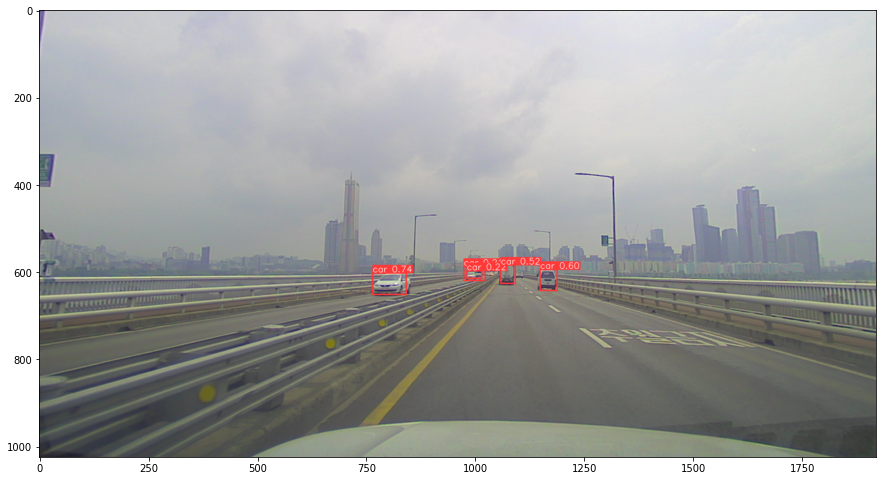

In [22]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result/run_image/1654752556636_FR-View-CMR-Wide.png'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

In [23]:
# image 파일 inference 
!cd /content/yolov5;python detect.py --source /content/drive/MyDrive/aimmo_yolo/images/train/1654752724495_FR-View-CMR-Wide.png \
                            --weights /content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/weights/best.pt --conf 0.2 \
                            --project=/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result --name=run_image --exist-ok --line-thickness 2

detect: weights=['/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/weights/best.pt'], source=/content/drive/MyDrive/aimmo_yolo/images/train/1654752724495_FR-View-CMR-Wide.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 267 layers, 46129818 parameters, 0 gradients, 107.7 GFLOPs
image 1/1 /content/drive/MyDrive/aimmo_yolo/images/train/1654752724495_FR-View-CMR-Wide.png: 352x640 25 cars, 2 others, 34.8ms
Speed: 0.5ms pre-process, 34.8ms inference, 1.5ms NMS per image at 

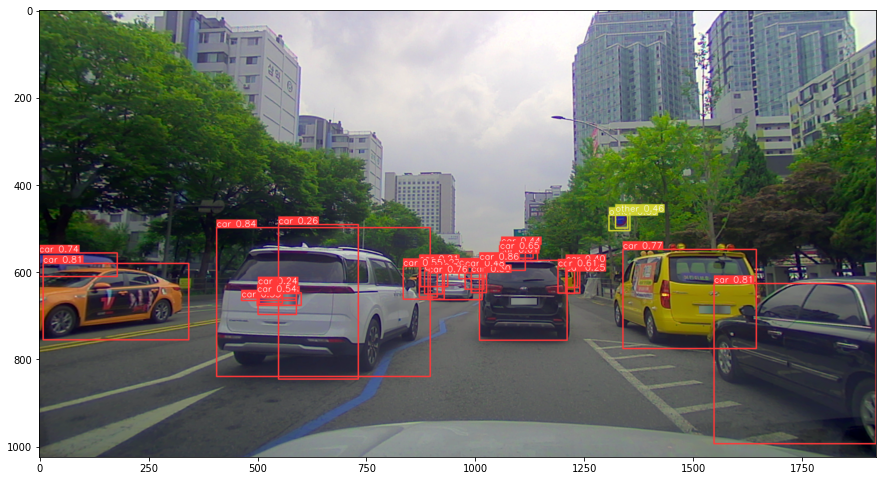

In [25]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result/run_image/1654752724495_FR-View-CMR-Wide.png'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

In [26]:
# image 파일 inference 
!cd /content/yolov5;python detect.py --source /content/drive/MyDrive/aimmo_yolo/images/train/1654752845894_FR-View-CMR-Wide.png \
                            --weights /content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/weights/best.pt --conf 0.2 \
                            --project=/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result --name=run_image --exist-ok --line-thickness 2

detect: weights=['/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/weights/best.pt'], source=/content/drive/MyDrive/aimmo_yolo/images/train/1654752845894_FR-View-CMR-Wide.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-267-gbe348cc Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 267 layers, 46129818 parameters, 0 gradients, 107.7 GFLOPs
image 1/1 /content/drive/MyDrive/aimmo_yolo/images/train/1654752845894_FR-View-CMR-Wide.png: 352x640 10 cars, 9 pedestrians, 2 others, 34.1ms
Speed: 0.5ms pre-process, 34.1ms inference, 1.4ms NM

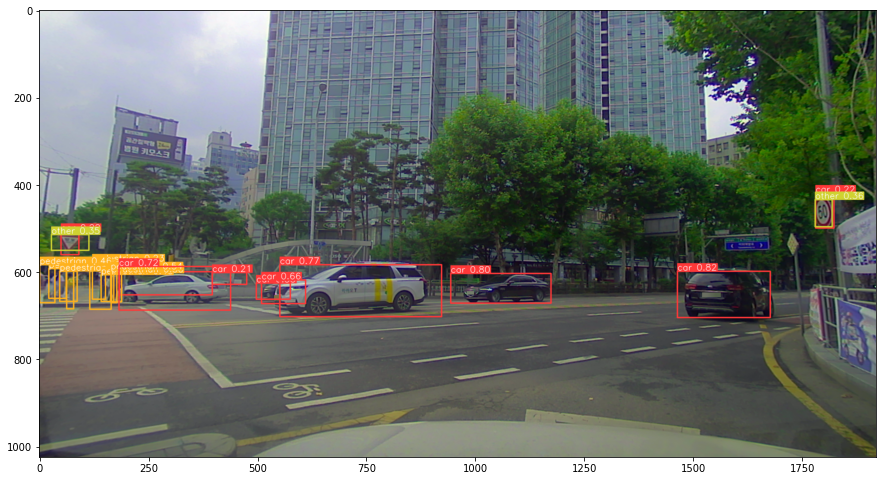

In [27]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/ultra_workdir/aimmo_yolo__v5/result/run_image/1654752845894_FR-View-CMR-Wide.png'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)